# Assignment 4
# Gemma Ragadini 545391

## Introduction
The goal of this project was to build a machine learning model capable of predicting the sentiment rating of online travel reviews based on the review text.
To simplify the problem and improve the model's performance, we converted the original multi-class rating system into a binary classification task, distinguishing between positive and negative reviews.
The following sections describe the data preprocessing steps, the architecture of the neural network model, and the evaluation of the model's performance.

In [ ]:
!pip install -q gdown gensim

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import gdown
from gensim.models import KeyedVectors
from kagglehub import KaggleDatasetAdapter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

## Data Preprocessing
Before training the model, we performed a series of preprocessing steps to clean and prepare the data for the classification.

In [ ]:
file_path = "Airline_Reviews.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "khushipitroda/airline-reviews",
  file_path,
)

df.head()

<ipython-input-3-097f136891bb>:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 6.52M/6.52M [00:00<00:00, 54.2MB/s]

Extracting zip of Airline_Reviews.csv...


,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [ ]:
print(df['Overall_Rating'].unique())

['9' '1' '8' '2' '3' '5' '6' '7' '4' 'n']


In [ ]:
# Remove all rows where Overall_Rating is 'n'
df = df[df['Overall_Rating'] != 'n']
print(df['Overall_Rating'].unique())

['9' '1' '8' '2' '3' '5' '6' '7' '4']


In [ ]:
# check for NaN values
df.isna().sum()

,0
Unnamed: 0,0
Airline Name,0
Overall_Rating,0
Review_Title,0
Review Date,0
Verified,0
Review,0
Aircraft,15200
Type Of Traveller,2896
Seat Type,568


In [ ]:
# check duplicates
duplicates = df[df.duplicated()]
print(f"Total duplicate rows: {len(duplicates)}")

Total duplicate rows: 0


In [ ]:
# excluding neutral reviews
df['Overall_Rating'] = df['Overall_Rating'].astype(int)
df = df[df['Overall_Rating'] != 5]

<ipython-input-8-a965a3703140>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Overall_Rating'] = df['Overall_Rating'].astype(int)


In [ ]:
# check for rows with low rating but recommended
inconsistent_low = df[(df['Overall_Rating'].astype(int) <= 4) & (df['Recommended'].str.lower() == 'yes')]
print("Low rating but recommended:")
inconsistent_low[['Overall_Rating', 'Recommended', 'Review']].head()

Low rating but recommended:


,Overall_Rating,Recommended,Review
15,1,yes,Frankfurt to Ljubljana. Flight was very comf...
23,1,yes,Two very short flights with Adria Airways fr...
31,1,yes,Tallinn to Stockholm with Adria Airways. Cle...
33,1,yes,Two short flights with Adria Airways (Ljublj...
41,1,yes,Excellent flights both ways with Adria Airways...


In [ ]:
# check for rows with high rating but not recommended
inconsistent_high = df[(df['Overall_Rating'].astype(int) >= 6) & (df['Recommended'].str.lower() == 'no')]
print("High rating but not recommended:")
inconsistent_high[['Overall_Rating', 'Recommended', 'Review']].head()

High rating but not recommended:


,Overall_Rating,Recommended,Review
135,6,no,Larnaca to Athens. I fly Aegean twice weekly ...
237,6,no,There was nothing wrong with the flight itse...
283,6,no,I had paid $50 in advance (on top of my airf...
403,6,no,One of the best things about AR is that they...
508,8,no,Puerto Escondido to Mexico City on Aeromar. Sm...


In [ ]:
# drop inconsistent rows
mask_low = (df['Overall_Rating'].astype(int) <= 4) & (df['Recommended'].str.lower() == 'yes')
mask_high = (df['Overall_Rating'].astype(int) >= 6) & (df['Recommended'].str.lower() == 'no')

inconsistent_mask = mask_low | mask_high

print(f"Original size: {len(df)}")

df = df[~inconsistent_mask].reset_index(drop=True)

print(f"New size: {len(df)}")

Original size: 21499
New size: 18777


In [ ]:
# count for each value
print(df['Overall_Rating'].value_counts())

Overall_Rating
1    9327
2    2264
9    1759
8    1722
3    1304
7    1130
4     777
6     494
Name: count, dtype: int64


In [ ]:
# creating Binary Sentiment Labels
df['Sentiment'] = df['Overall_Rating'].apply(lambda x: 1 if x > 5 else 0)
# merging the Review_Title and Review
df['Review'] = df['Review_Title'].str.strip('"') + ' ' + df['Review']
# Convert to lowercase
df['Review'] = df['Review'].apply(lambda x: x.lower())
# Remove special characters (keep only letters, numbers, spaces and also !,?and .)
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s!?.]', '', x))
# View the result
df[['Review', 'Overall_Rating', 'Sentiment']].head()

,Review,Overall_Rating,Sentiment
0,pretty decent airline moroni to moheli. turn...,9,1
1,not a good airline moroni to anjouan. it is a...,1,0
2,flight was fortunately short anjouan to dzao...,1,0
3,i will never fly again with adria please do ...,1,0
4,it ruined our last days of holidays do not bo...,1,0


In [ ]:
print(df['Sentiment'].value_counts())

Sentiment
0    13672
1     5105
Name: count, dtype: int64


## Subsample and Split Train vs Internal Test set
We split the dataset into training and internal test sets, using an 80/20 ratio.
Stratified sampling is applied to preserve the original sentiment class distribution in both subsets.

In [ ]:
# split the dataset into training and testing subsets
X = df['Review']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Tokenization
We initialize a Keras tokenizer with a vocabulary size limit of 30,000 words and an out-of-vocabulary token (<OOV>).
The tokenizer is fitted on the training set and then used to convert both the training and test texts into sequences of integer tokens.

In [ ]:
# Set vocabulary size
max_words = 10000

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# fit the tokenizer on TR set
tokenizer.fit_on_texts(X_train)

# tokenize TR set
train_sequences = tokenizer.texts_to_sequences(X_train)
# tokenize TS set
test_sequences = tokenizer.texts_to_sequences(X_test)

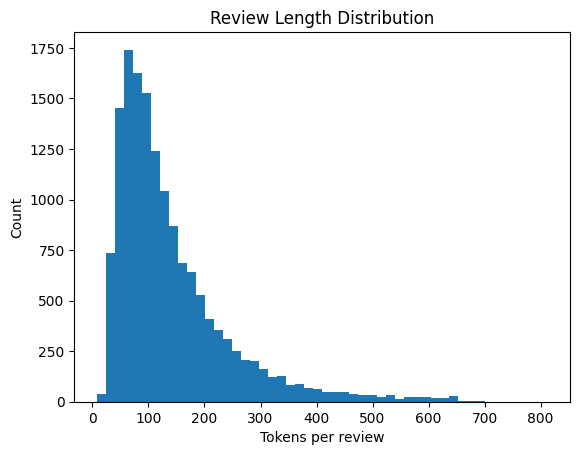

In [ ]:
# analyzing review length
lengths = [len(seq) for seq in train_sequences]
plt.hist(lengths, bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

In [ ]:
print("95th percentile length:", np.percentile(lengths, 95))

95th percentile length: 347.0


We pad all input sequences to a fixed length of 347 tokens. Padding and truncation are applied at the beginning of the sequences ('pre') to ensure uniform input size for the model.

In [ ]:
max_len = 347
# pad train seq.
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='pre', truncating='pre')
# pad test seq.
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='pre', truncating='pre')

## Word2Vec
To enrich the textual data with semantic information, I used pretrained word embeddings from the Google News Word2Vec model. This model was trained on a large corpus of news articles and provides 300-dimensional vector representations for approximately 3 million English words and phrases.

I downloaded the pretrained binary file `GoogleNews-vectors-negative300.bin`. Once downloaded, I loaded the embeddings using the `KeyedVectors` class from the `gensim` library.  Using these embeddings allows our model to benefit from a rich representation of language without needing to learn word meanings from scratch during training. To preserve the quality of these vectors, the embedding layer in the model was set to be non-trainable.

In [ ]:
file_id = '1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy'
output_path = 'GoogleNews-vectors-negative300.bin'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output=output_path, quiet=False)
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Downloading...
From (original): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy
From (redirected): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy&confirm=t&uuid=d5658226-5e02-4ac8-bc9d-7efca446e0d6
To: /content/GoogleNews-vectors-negative300.bin
100%|██████████| 3.64G/3.64G [00:16<00:00, 226MB/s]


We build the embedding matrix by assigning pre-trained Word2Vec vectors to the words in our vocabulary.
Words not found in the Word2Vec model are initialized with random values drawn from a normal distribution (mean = 0, std = 0.6).

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in w2v_model:
            embedding_matrix[i] = w2v_model[word]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


## Model Definition

We define a neural network architecture consisting of:

- a frozen embedding layer initialized with pretrained Word2Vec vectors to provide rich semantic representations of words,
- an LSTM layer with 128 units, including dropout and recurrent dropout, to capture sequential dependencies and mitigate overfitting,
- a dense layer with 64 ReLU-activated units to introduce non-linearity and learn complex patterns,
- and a final dense layer with sigmoid activation for binary classification output.

The embedding layer is set to trainable=False to preserve the quality of the pretrained vectors. The model is compiled using binary crossentropy loss and the Adam optimizer, suitable for binary classification tasks. Dropout layers are included to reduce the risk of overfitting by randomly deactivating neurons during training.

In [ ]:
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Upon inspecting the distribution of sentiment labels in the training set, I observed a significant class imbalance with one class (negative) being much more frequent than the other.  To address this, I applied class weighting,  assigning higher importance to underrepresented class during training. Specifically, I used `compute_class_weight` from `sklearn.utils.class_weight` with the 'balanced' mode, which automatically calculates weights inversely proportional to class frequencies.

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

The model was trained for a maximum of 5 epochs with a batch size of 64, using 20% of the training data for validation. To prevent overfitting and ensure efficient training, we used early stopping.

## Training

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(train_sequences_padded, y_train,
          epochs=5,
          batch_size=64,
          validation_split=0.2,
          class_weight=class_weight_dict,
          callbacks=[early_stop])

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 193s 988ms/step - accuracy: 0.7507 - loss: 0.5480 - val_accuracy: 0.7228 - val_loss: 0.4406
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 196s 975ms/step - accuracy: 0.6591 - loss: 0.5298 - val_accuracy: 0.8396 - val_loss: 0.3786
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 201s 973ms/step - accuracy: 0.8427 - loss: 0.4319 - val_accuracy: 0.8486 - val_loss: 0.4644
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 202s 975ms/step - accuracy: 0.7928 - loss: 0.4286 - val_accuracy: 0.8815 - val_loss: 0.3369
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 203s 980ms/step - accuracy: 0.8728 - loss: 0.3419 - val_accuracy: 0.9052 - val_loss: 0.2458


## Results

After training, we evaluate the model's performance on the test set using standard classification metrics. The results demonstrate that the model generalizes well to unseen data:

- Negative reviews is identified with high precision and recall, indicating the model is very reliable when predicting negative sentiment.
- Positive reviews despite being the minority class, still achieves solid performance. This shows that the model is effective at identifying positive sentiment even in the presence of class imbalance.

Overall metrics (accuracy, macro avg f1-score, weighted svg f1-score)  confirm that the model maintains a good balance between precision and recall across both classes. The use of class weighting during training helped mitigate the effect of class imbalance, allowing the model to perform robustly on both the majority and minority classes.

In [ ]:
y_pred_prob = model.predict(test_sequences_padded)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2735
           1       0.82      0.88      0.85      1021

    accuracy                           0.91      3756
   macro avg       0.89      0.90      0.89      3756
weighted avg       0.92      0.91      0.92      3756

Confusion Matrix:
[[2542  193]
 [ 127  894]]
